In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *

In [2]:
from helpers.notebooks import notebooks_importer

In [3]:
%%capture
import Data as data

In [4]:
from signature_scoring.scoring_functions.gsea import create_gsea_scorer
from methods.gsea import cudaGSEA

In [5]:
from functools import partial

In [6]:
from signature_scoring.evaluation.benchmark import benchmark

In [12]:
from signature_scoring.evaluation.display import summarize

In [7]:
standard_benchmark = partial(
    benchmark,
    top='quantile',                           # criterium for selection of the candidated repositioning substances; quantile: choose top 10%
    summary='per_cell_line_combined',         # use combine() method of evaluation metrics to combine metrics results calculated for each of the cell lines
    aggregate='mean_per_substance_and_dose',  # same as "mean_per_substance_dose_and_cell" because summary is computed per cell line anyway (see above)
    cell_lines_ratio=.75,                     # at least such a ratio of substances signatures should be available for the cell line to include it
    limit=500,                                # how many under- and over- expressed genes should be analyzed
    processes=12,
    per_test_progress=False
)

## Some notes on cudaGSEA

### Versions:
- Driver Version: 415.27
- CUDA Version: 10.0
- GeForce GTX 950M (640 GPU cores, 4046 MB)

cudaGSEA is executed one by one on the GPU core but the time when it is not being executed can be used to prepare the queue for the GPU core. So the number of processes basically tells how many tasks I wish to put on the queue.

Each task takes up to ~140 MB when 1000 permutations is used. My Nvidia card has 4046 MiB so it should be possible to have 28 processes up and waiting. However, in the benchmark below I use only seven cores as the Java version runs on CPU only.

# Results

## 1. cudaGSEA provides results very close to those of original GSEA

In [8]:
q = 0.5
p = 250

tcga_genes = set(data.query_signature.index.astype(str))

common_gsea_setup = partial(
    create_gsea_scorer,
    permutations=p, gene_sets='c2.cp.kegg', q_value_cutoff=q,
    permutation_type='phenotype', grouping='by_substance',
    verbose=False, genes=tcga_genes
)

gsea_score_phenotypes_java = common_gsea_setup(
    metric='Signal2Noise'
)

gsea_score_phenotypes_cuda = common_gsea_setup(
    gsea_app=cudaGSEA(),
    metric='onepass_signal2noise'
)

In [9]:
standard_brca_benchmark = partial(
    standard_benchmark,
    [gsea_score_phenotypes_java, gsea_score_phenotypes_cuda],
    data.query_signature,
)

standard_brca_benchmark.keywords['processes'] = 7

In [10]:
results = standard_brca_benchmark(
    data.indications_singatures, data.contraindications_singatures, data.all_control_signatures,
    query_expression=data.brca_with_controls
)

'Iteration: 236/250 for tmpb2xqotrv.tmpr_zum3vj'

'Iteration: 241/250 for tmpb2xqotrv.tmpr_zum3vj'

'Iteration: 236/250 for tmph3vv7w4y.tmp211xqsl7'

'Iteration: 241/250 for tmpb2xqotrv.tmpr_zum3vj'

'Iteration: 246/250 for tmpb2xqotrv.tmpr_zum3vj'

'Finished permutations ... creating reports'

'8541 [INFO ] Already a synched dataset-template -- NO extracting done'

'Creating marker selection reports ...'

'Done all reports!!'

'Finished permutations ... creating reports'

'9123 [INFO ] Already a synched dataset-template -- NO extracting done'

'Creating marker selection reports ...'

'Creating FDR reports ...'

'Done FDR reports for positive phenotype'

'Done FDR reports for negative phenotype'

'Creating global reports ...'

'Done all reports!!'

Using top > 0.1 quantile to select top results.
Testing cudaGSEA_250_c2.cp.kegg_mean_0.5_fill_0_True_phenotype_onepass_signal2noise


Output()

/home/krassowski/drug_discovery/code/signature_scoring/scoring_functions/gsea.py:69: UserWarning: Warning: not using cache (that's fine if it's the first run)
  warn('Warning: not using cache (that\'s fine if it\'s the first run)')
/home/krassowski/drug_discovery/code/methods/gsea/base.py:103: UserWarning: Too few samples for the metric onepass_signal2noise
  warn(f'Too few samples for the metric {metric}')
/home/krassowski/drug_discovery/code/methods/gsea/base.py:103: UserWarning: Too few samples for the metric onepass_signal2noise
  warn(f'Too few samples for the metric {metric}')
/home/krassowski/drug_discovery/code/methods/gsea/base.py:103: UserWarning: Too few samples for the metric onepass_signal2noise
  warn(f'Too few samples for the metric {metric}')


In [13]:
summarize(results)

## 2. FDR q-value cutoff is detrimental for cudaGSEA

In [83]:
grid = [i/20 for i in range(1, 20)]
grid

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [156]:
p = 1000
functions = []
for q in grid:
    gsea_score_phenotypes_cuda = create_gsea_scorer(
        gsea_app=cudaGSEA(),
        permutations=p, gene_sets='c2.cp.kegg', q_value_cutoff=q,
        permutation_type='phenotype', grouping='by_substance',
        metric='onepass_signal2noise',
        verbose=False,
        genes=set(data.query_signature.index.astype(str))
    )
    functions.append(gsea_score_phenotypes_cuda)

In [157]:
standard_brca_benchmark = partial(standard_benchmark, functions, data.query_signature)
standard_brca_benchmark.keywords['processes'] = 8
fdr_benchmark = partial(
    standard_brca_benchmark,
    data.indications_singatures, data.contraindications_singatures, data.all_control_signatures,
    query_expression=data.brca_with_controls
)

In [158]:
fdr_results = []

for i in range(3):
    fdr_results.append(fdr_benchmark())

In [4]:
results_q_cutoff = concat(fdr_results)

In [161]:
# results_q_cutoff.to_csv('cudaGSEA benchmarks/results_q_cutoff.csv')

In [162]:
q_value_data = DataFrame(dict(
    q_cutoff=results_q_cutoff.index.str.split('_').str[4],
    tradeoff=results_q_cutoff['indications:F1 Score'] - results_q_cutoff['contraindications:F1 Score']
))

In [ ]:
%load_ext rpy2.ipython

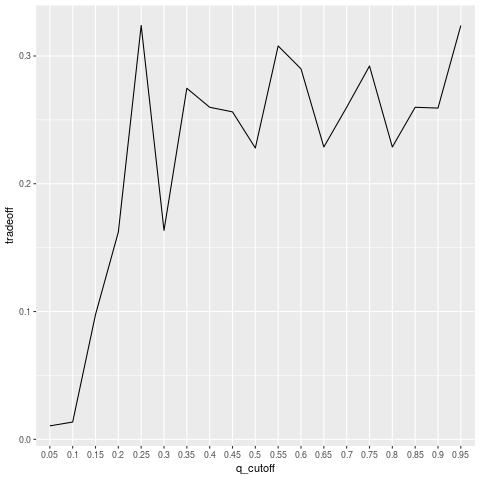

In [163]:
%%R -i q_value_data
require(ggplot2)
(
    ggplot(q_value_data, aes(x=q_cutoff, y=tradeoff, group=1))
    + stat_summary(geom='line', fun.y=mean)
    # the ribbon won't work with 3 points - revisit with more repeats if time permits
    + stat_summary(geom="ribbon", fun.data=mean_cl_normal, colour=NA, alpha=0.1)
)

## 3. Naive metrics perform worse than the non-naive metrics

and (obviously) this does not change when we calculate the naive metrics with numerically stable algorithms.


There are no visible benefits of using numerically stable (two-pass/stable/overkill) implementations of signal-to-noise or t-test metrics.

In [164]:
metrics = [
    'naive_diff_of_classes',
    'naive_ratio_of_classes',
    'naive_log2_ratio_of_classes',
    'stable_diff_of_classes',
    'stable_ratio_of_classes',
    'stable_log2_ratio_of_classes',
    'onepass_t_test',
    'onepass_signal2noise',
    'twopass_signal2noise',
    'twopass_t_test',
    'stable_signal2noise',
    'stable_t_test',
    'overkill_signal2noise',
    'overkill_t_test'
]
reduced_grid = [0.45, 0.5, 0.55]

In [23]:
functions_metrics_test = []
for metric in metrics:
    for q in reduced_grid:
        gsea_score_phenotypes_cuda = create_gsea_scorer(
            gsea_app=cudaGSEA(),
            permutations=p, gene_sets='c2.cp.kegg', q_value_cutoff=q,
            permutation_type='phenotype', grouping='by_substance',
            metric=metric,
            verbose=False,
            genes=set(data.query_signature.index.astype(str))
        )
        functions_metrics_test.append(gsea_score_phenotypes_cuda)

In [24]:
standard_brca_benchmark = partial(standard_benchmark, functions_metrics_test, data.query_signature,)
standard_brca_benchmark.keywords['processes'] = 8

metrics_benchmark = partial(
    standard_brca_benchmark,
    data.indications_singatures, data.contraindications_singatures, data.all_control_signatures,
    query_expression=data.brca_with_controls
)

In [24]:
metrics_results = []
for i in range(3):
    result = metrics_benchmark()
    metrics_results.append(result)

In [119]:
metrics_results = concat(metrics_results)

In [152]:
# metrics_results.to_csv('cudaGSEA benchmarks/metrics_results.csv')

In [121]:
metrics_data = DataFrame(dict(
    tradeoff=metrics_results['indications:F1 Score'] - metrics_results['contraindications:F1 Score'],
    metric=metrics_results.index.str.split('_').str[9:].str.join('_'),
    group=metrics_results.index.str.split('_').str[9],
    time=metrics_results['Time']
))

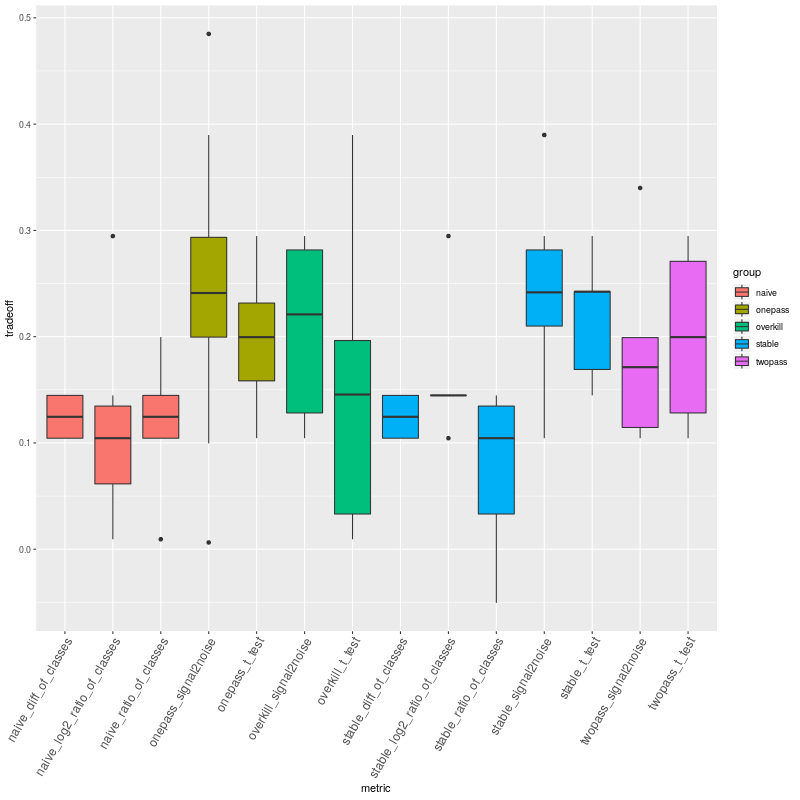

In [122]:
%%R -i metrics_data -w 800 -h 800 -u px
require(ggplot2)
(
    ggplot(metrics_data, aes(x=metric, y=tradeoff, group=metric, fill=group))
    + geom_boxplot()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

## 4. Naive metrics are faster.

Stable metrics appear to be faster, but it's only because there are stable implementations of naive metrics in this group.

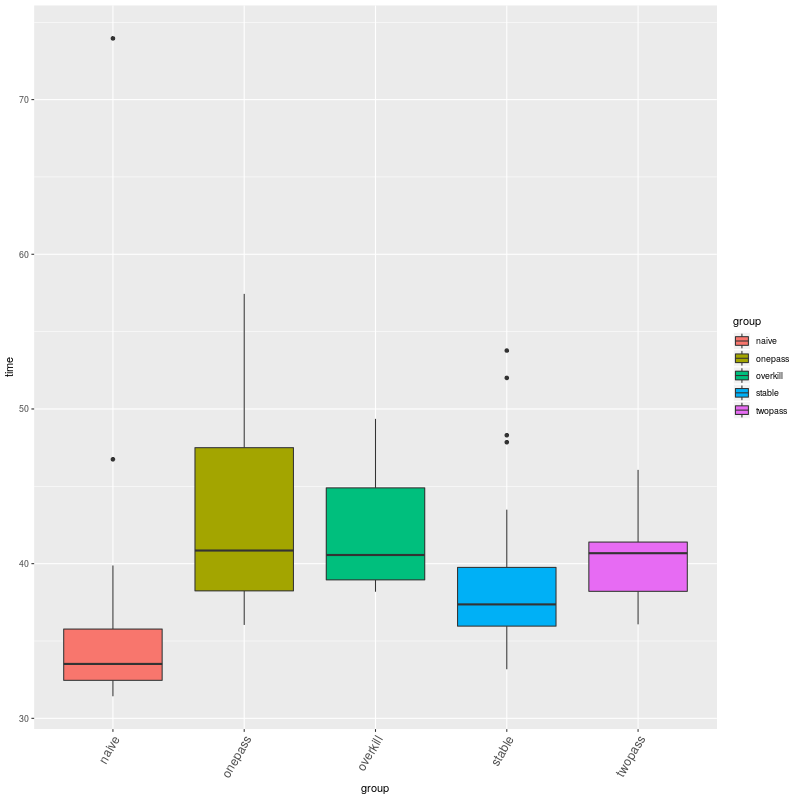

In [148]:
%%R -i metrics_data -w 800 -h 800 -u px
require(ggplot2)
(
    ggplot(metrics_data, aes(x=group, y=time, group=group, fill=group))
    + geom_boxplot()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

In [149]:
stable_limited = metrics_data[~metrics_data.metric.isin(
    ['stable_diff_of_classes', 'stable_log2_ratio_of_classes', 'stable_ratio_of_classes']
)]

Below one can see that there are no significant execution time differences among non-naive metrics:

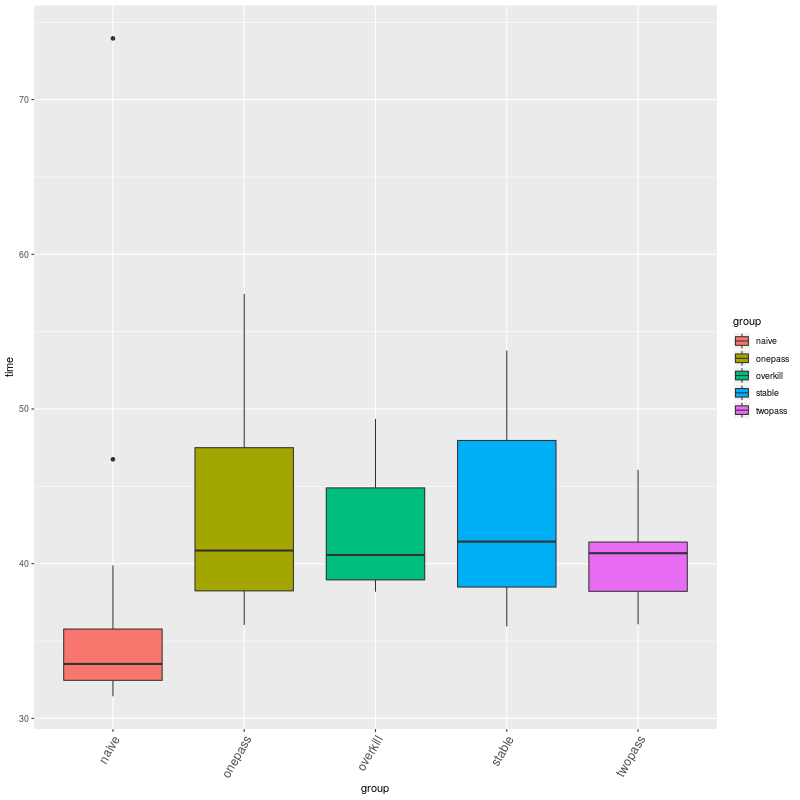

In [151]:
%%R -i stable_limited -w 800 -h 800 -u px
require(ggplot2)
(
    ggplot(stable_limited, aes(x=group, y=time, group=group, fill=group))
    + geom_boxplot()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)